In [1]:
import netCDF4 as nc
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append("../")
from src import visualization as vis
from src import data
from src import data_products as dp

In [2]:
def get_settled(a, s):
    asett = np.ma.MaskedArray(a, mask=s)
    return asett[asett.mask].data

def get_settled_particles(x, y, s):
    xsett = get_settled(x, s)
    ysett = get_settled(y, s)
    
    return xsett, ysett

In [6]:
def concatenate_years(years1):
    
    period = "baseline" if years1[0] < 2000 else "warm"
    sy = 1984 if years1[0] < 2000 else 2012

    fname84 = "../data/model_sims/{}/american-butterfish/{}/settlement.nc".format(period, sy)
    ds = nc.Dataset(fname84)
    variables = []
    for v in ds.variables:
        variables.append(v)

    master_vars = []
    for v in variables:
        va = np.zeros(shape=(1,))
        master_vars.append(va)

    years = np.zeros(shape=(1,))

    for y in years1:
        fname = "../data/model_sims/{}/american-butterfish/{}/settlement.nc".format(period, y)
        dset = nc.Dataset(fname)

        size = dset.dimensions['num_particles'].size    
        for i, v in enumerate(variables):
            var = dset[v][:].data
            mv = master_vars[i]
            mv = np.concatenate((mv, var))
            master_vars[i] = mv

        ys = np.full(size, y)

        years = np.concatenate((years, ys), axis=0)

        dset.close()

    master_vars.append(years)
    variables.append("years")
    
    settle_fname="../data/model_sims/{}/american-butterfish/settlement.nc".format(period)
    if os.path.exists(settle_fname):
        os.remove(settle_fname)

    annual = nc.Dataset(settle_fname, 'w', format="NETCDF4")

    mvs = master_vars

    annual.createDimension("num_particles", mvs[0].shape[0])

    nc_variables = []
    for i, mv in enumerate(mvs):
        var = annual.createVariable(variables[i], "f8", ("num_particles"))
        var[:] = mv
        nc_variables.append(var)

    annual.close()
    
    return master_vars

In [16]:
concatenate_years(range(1984, 1989))
concatenate_years(range(2012, 2017))

[array([0.0000000e+000, 1.7007610e+006, 1.7107950e+006, ...,
        1.4288900e+006, 1.4272100e+006, 3.9456557e-317]),
 array([0.00000000e+000, 4.20487000e+005, 4.10027000e+005, ...,
        3.04238000e+005, 3.04329000e+005, 4.63557072e-310]),
 array([0.00e+000, 1.49e+002, 1.47e+002, ..., 1.53e+002, 1.66e+002,
        5.43e-323]),
 array([0.00000000e+000, 1.70076134e+006, 1.71079583e+006, ...,
        5.41145998e+005, 5.19755129e+005, 2.31784051e-310]),
 array([ 0.00000000e+000,  4.20487706e+005,  4.10027385e+005, ...,
        -3.92287774e+005, -4.31639422e+005,  2.31784051e-310]),
 array([  0.        , 200.        , 198.        , ..., 201.        ,
        217.        , -67.77378863]),
 array([0., 1., 1., ..., 1., 1., 0.]),
 array([   0., 2012., 2012., ..., 2016., 2016., 2016.])]

In [24]:
dset = nc.Dataset("../data/model_sims/warm/yellowtail-flounder/settlement.nc")
xs, ys, ss = dset['final_lons'][:].data, dset['final_lats'][:].data, dset['settled_particles'][:].data

In [25]:
np.count_nonzero(ss == 1)/(len(ss))

0.3790510518411507

In [26]:
xsett, ysett = get_settled_particles(xs, ys, ss)

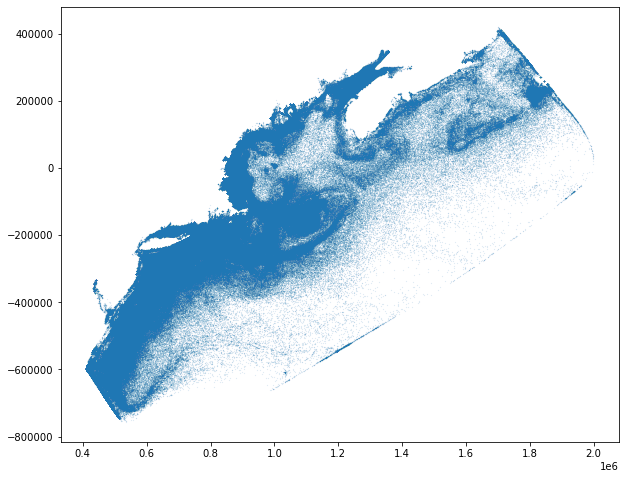

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(xsett, ysett, s=0.01, alpha=0.5)

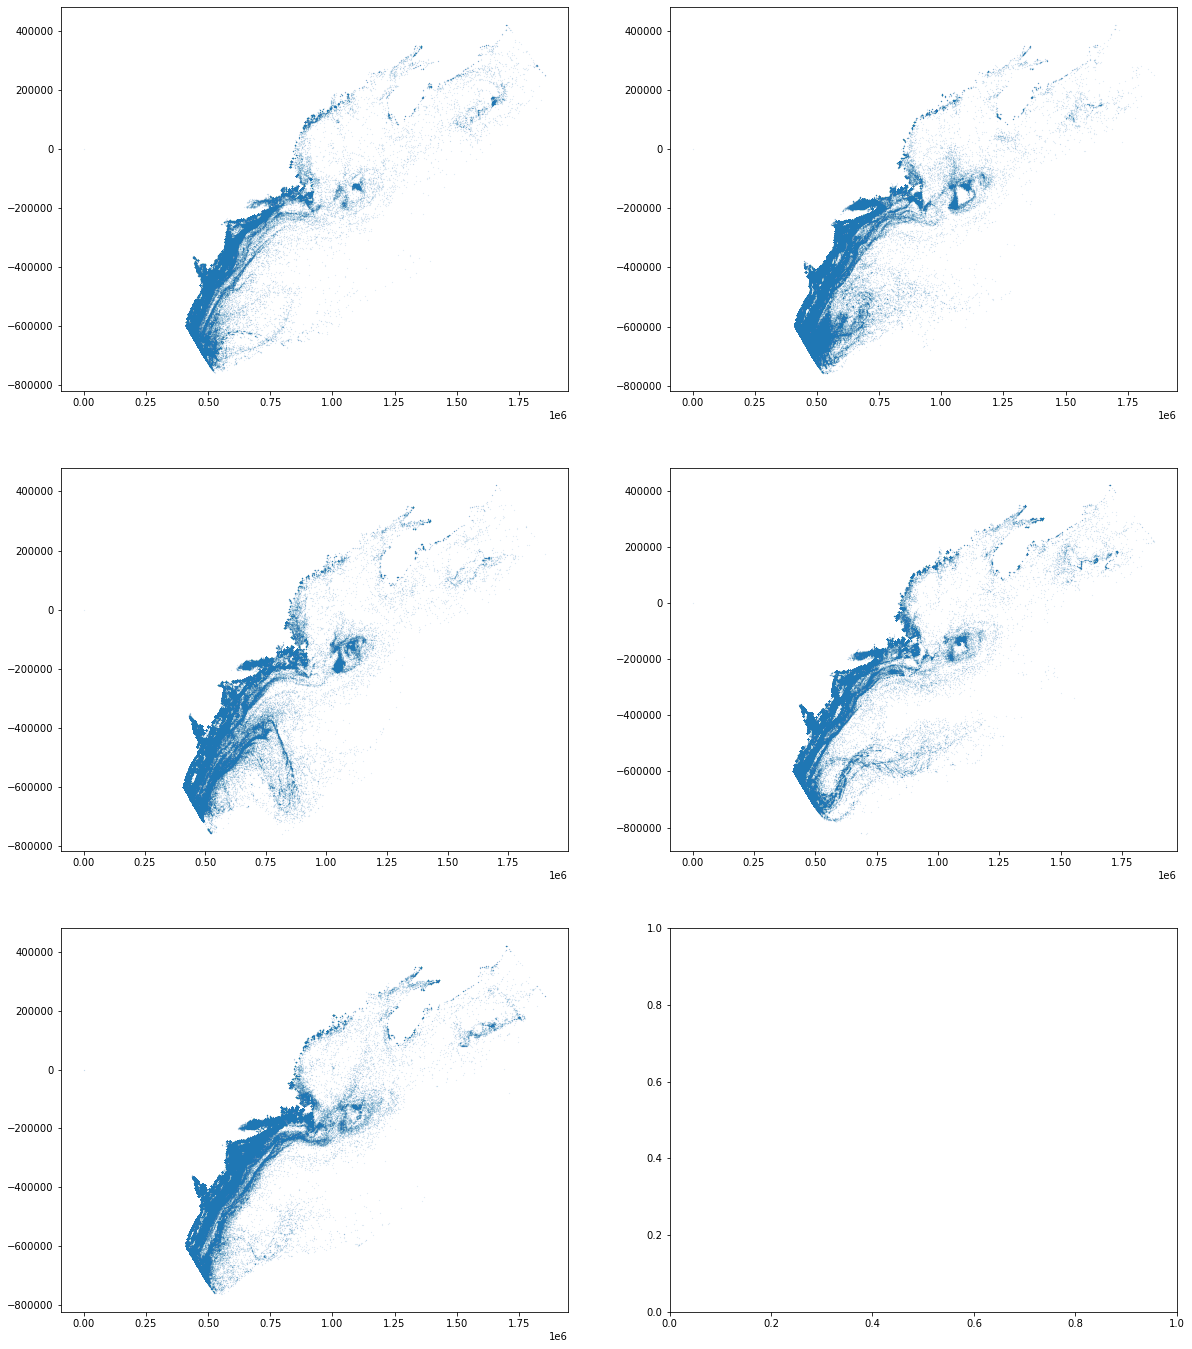

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.ravel()
for i in range(5):
    ax = axes[i]
    dset = nc.Dataset("../data/model_sims/baseline/american-butterfish/{}/settlement.nc".format(1984+i))
    xs, ys, ss = dset['final_lons'][:].data, dset['final_lats'][:].data, dset['settled_particles'][:].data
    xsett, ysett = get_settled_particles(xs, ys, ss)
    ax.scatter(xsett, ysett, s=0.01, alpha=0.5)

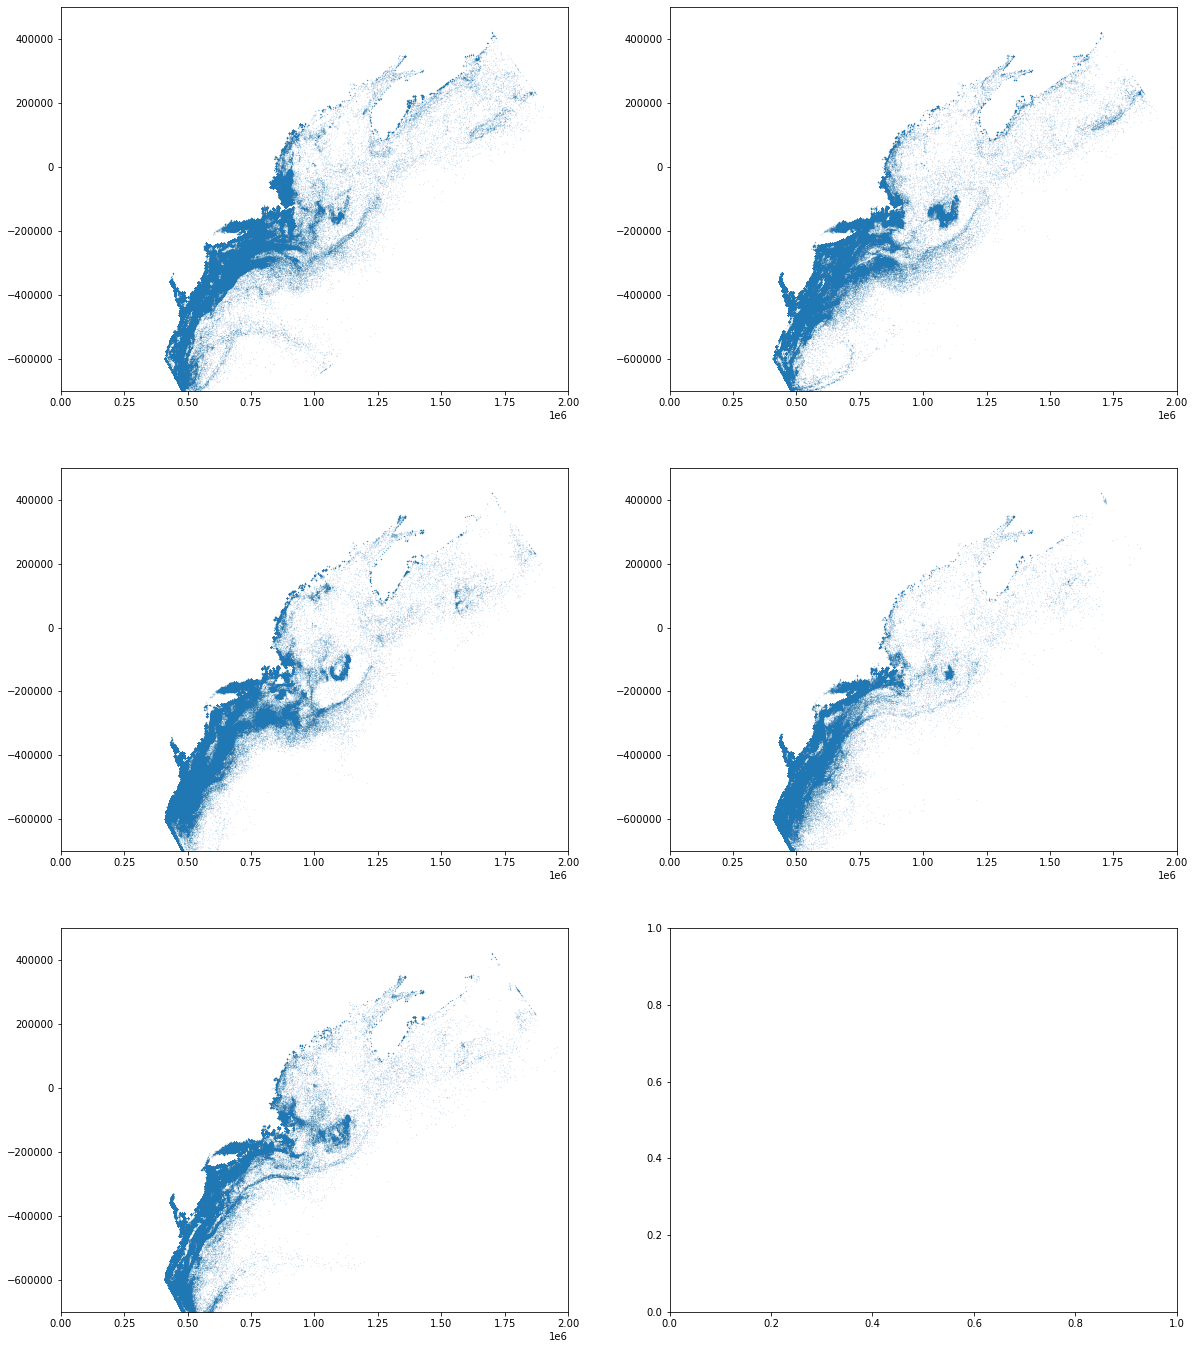

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.ravel()
for i in range(5):
    ax = axes[i]
    dset = nc.Dataset("../data/model_sims/warm/american-butterfish/{}/settlement.nc".format(2012+i))
    xs, ys, ss = dset['final_lons'][:].data, dset['final_lats'][:].data, dset['settled_particles'][:].data
    xsett, ysett = get_settled_particles(xs, ys, ss)
    ax.scatter(xsett, ysett, s=0.01, alpha=0.5)
    ax.set_xlim((0, 2e6))
    ax.set_ylim(-700000, 500000)

In [113]:
xs, ys, ss, years = master_vars[3][1:], master_vars[4][1:], master_vars[-2][1:], master_vars[-1][1:]

In [114]:
xsett, ysett = get_settled_particles(xs, ys, ss)
years_sett = get_settled(years, ss)

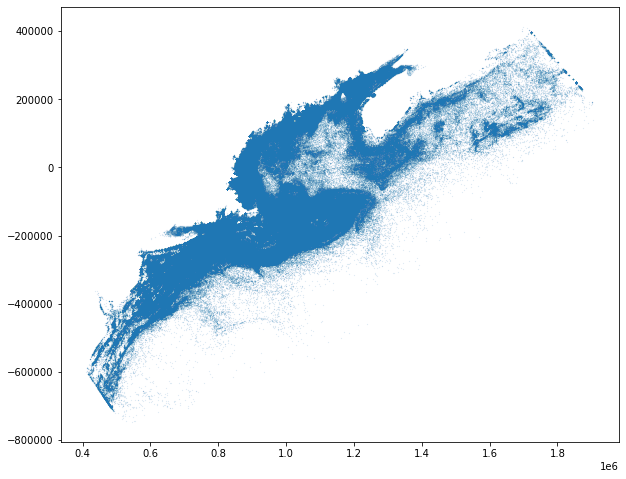

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(xsett, ysett, s=0.01, alpha=0.5)

In [3]:
def create_dict(dset):
    variables = dset.variables
    data = {}
    
    for v in dset.variables:
        data[v] = dset[v][:].data
        
    return data

In [8]:
dset_base = nc.Dataset("../data/model_sims/baseline/atlantic-mackerel/settlement.nc")
data_base = create_dict(dset_base)
init_xs, init_ys, init_ts = data_base['init_lons'], data_base['init_lats'], data_base['init_times']
final_xs, final_ys, final_ts = data_base['final_lons'], data_base['final_lats'], data_base['final_times']
years, settled = data_base['years'], data_base['settled_particles']

init_lons, init_lats = project(init_xs, init_ys, to_lola=True)
final_lons, final_lats = project(final_xs, final_ys, to_lola=True)

data_base['init_lons'], data_base['init_lats'] = init_lons, init_lats
data_base['final_lons'], data_base['final_lats'] = final_lons, final_lats

xsett, ysett = get_settled_particles(final_xs, final_ys, settled)
years_sett = get_settled(years, settled)

In [10]:
dset_warm = nc.Dataset("../data/model_sims/warm/atlantic-mackerel/settlement.nc")
data_warm = create_dict(dset_warm)
init_xs, init_ys, init_ts = data_warm['init_lons'], data_warm['init_lats'], data_warm['init_times']
final_xs, final_ys, final_ts = data_warm['final_lons'], data_warm['final_lats'], data_warm['final_times']
years, settled = data_warm['years'], data_warm['settled_particles']

init_lons, init_lats = project(init_xs, init_ys, to_lola=True)
final_lons, final_lats = project(final_xs, final_ys, to_lola=True)

data_warm['init_lons'], data_warm['init_lats'] = init_lons, init_lats
data_warm['final_lons'], data_warm['final_lats'] = final_lons, final_lats

xsett, ysett = get_settled_particles(final_xs, final_ys, settled)
years_sett = get_settled(years, settled)

In [4]:
import pyproj as proj
def project(x, y, to_lola=False):
    proj_out = proj.Proj('esri:102284')

    xproj, yproj = proj_out(x, y, inverse=to_lola)

    return xproj, yproj	

In [6]:
def add_region_names(data):

    regions = gpd.read_file("../auxdata/trawl-strata/seven-region-small/seven-regions-strata-small.shp")

    init_d = {}
    final_d = {}

    for k in data.keys():
        if "init" in k:
            init_d[k] = data[k]
        elif "final" in k:
            final_d[k] = data[k]
        else:
            init_d[k] = data[k]
            final_d[k] = data[k]

    init_points = pd.DataFrame(data=init_d)
    final_points = pd.DataFrame(data=final_d)

    init_points = gpd.GeoDataFrame(init_points, geometry=gpd.points_from_xy(init_points['init_lons'], init_points['init_lats']))
    final_points = gpd.GeoDataFrame(final_points, geometry=gpd.points_from_xy(final_points['final_lons'], final_points['final_lats']))

    init_points_join = gpd.sjoin(regions, init_points, how="right", op="contains")
    init_psj = init_points_join.drop(columns=["index_left", "OBJECTID", "FINSTR_ID", "STRATA", "A2", "STR2", "SET_", "STRATUMA", "ZERO", "STR3", "area", "Shape_Leng", "Shape_Area", "area_km2"])
    init_psjd = init_psj.dropna(subset=["REGION_NAM"])
    init_psjd = init_psjd.rename(columns={"REGION_NAM": "init_region"})

    final_points_join = gpd.sjoin(regions, final_points, how="right", op="contains")
    final_psj = final_points_join.drop(columns=["index_left", "OBJECTID", "FINSTR_ID", "STRATA", "A2", "STR2", "SET_", "STRATUMA", "ZERO", "STR3", "area", "Shape_Leng", "Shape_Area", "area_km2"])
    final_psjd = final_psj.dropna(subset=["REGION_NAM"])
    final_psjd = final_psjd.rename(columns={"REGION_NAM": "final_region"})

    psjd = init_psjd.join(final_psjd, how="right", lsuffix="_init")
    psjd = psjd.drop(columns=["years_init", "settled_particles_init"])
    psjd = psjd[["init_lons", "init_lats", "init_times", "init_region", "final_lons", "final_lats", "final_times", "final_region", "years", "settled_particles"]]


    return psjd
    

In [68]:
#psjd = psjd.drop(columns=["years_init", "settled_particles_init"])
#psjd = psjd[["init_lons", "init_lats", "init_times", "init_region", "final_lons", "final_lats", "final_times", "final_region", "years", "settled_particles"]]

psjd.to_csv("../data/model_sims/baseline/atlantic-cod/settled_data.csv")

In [9]:
base_psjd = add_region_names(data_base)
base_psjd.to_csv("../data/model_sims/baseline/atlantic-mackerel/settled_data.csv")

/vortexfs1/home/jzahner/.conda/envs/larval-dispersal-modeling/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:6318
Right CRS: None

/vortexfs1/home/jzahner/.conda/envs/larval-dispersal-modeling/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:6318
Right CRS: None



In [11]:
warm_psjd = add_region_names(data_warm)
warm_psjd.to_csv("../data/model_sims/warm/atlantic-mackerel/settled_data.csv")

/vortexfs1/home/jzahner/.conda/envs/larval-dispersal-modeling/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:6318
Right CRS: None

/vortexfs1/home/jzahner/.conda/envs/larval-dispersal-modeling/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:6318
Right CRS: None



In [58]:
data_base

{'init_lons': array([-81.07722606, -59.81892965, -59.82182921, ..., -63.48588865,
        -63.42897538, -63.42480353]),
 'init_lats': array([42.31071301, 46.14286086, 46.14806923, ..., 45.31044979,
        45.37572617, 45.37227523]),
 'init_times': array([  0.,  48.,  38., ..., 163., 152., 157.]),
 'final_lons': array([-81.07722606, -59.81891888, -59.82182573, ..., -63.48588664,
        -63.42896372, -63.4247927 ]),
 'final_lats': array([42.31071301, 46.14286129, 46.14806906, ..., 45.3104514 ,
        45.3757327 , 45.37227705]),
 'final_times': array([  0., 105.,  94., ..., 221., 210., 213.]),
 'settled_particles': array([0., 0., 0., ..., 0., 0., 1.]),
 'years': array([   0., 1984., 1984., ..., 1988., 1988., 1988.])}

In [5]:
b = pd.read_csv("../data/model_sims/baseline/american-butterfish/settled_data.csv")

In [9]:
b.dropna()

,Unnamed: 0,init_lons,init_lats,init_times,init_region,final_lons,final_lats,final_times,final_region,years,settled_particles
0,1,-59.810814,46.139687,149.0,Scotian Shelf,-63.246409,44.371294,198.0,Scotian Shelf,1984.0,0.0
2,5,-59.705645,46.041453,141.0,Scotian Shelf,-59.886739,45.338294,195.0,Scotian Shelf,1984.0,0.0
3,6,-59.646885,45.970417,132.0,Scotian Shelf,-60.489981,45.257108,176.0,Scotian Shelf,1984.0,0.0
4,7,-59.569069,45.900014,140.0,Scotian Shelf,-63.564994,43.925850,193.0,Scotian Shelf,1984.0,0.0
5,8,-59.157423,45.476153,137.0,Scotian Shelf,-59.216888,45.526855,189.0,Scotian Shelf,1984.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3686678,4989804,-63.488286,45.317799,173.0,Bay of Fundy,-63.491566,45.333129,221.0,Bay of Fundy,1988.0,1.0
3686679,4989806,-63.489995,45.320401,154.0,Bay of Fundy,-63.480398,45.332637,198.0,Bay of Fundy,1988.0,1.0
3686680,4989807,-63.484586,45.317815,179.0,Bay of Fundy,-63.503105,45.335322,225.0,Bay of Fundy,1988.0,1.0
3686686,4989830,-63.433438,45.363464,170.0,Bay of Fundy,-64.554368,45.387100,220.0,Bay of Fundy,1988.0,1.0
